# Import of libraries and data, and preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from files.preprocessing import *

In [2]:
data_raw=pd.read_csv("./data/Train.csv")
meta=pd.read_csv("./data/airqo_metadata.csv")

In [3]:
features_pretty = {'temp': 'Temperature', 'wind_dir': 'Wind direction', 'wind_spd': 'Wind speed', 'rel_humidity': 'Rel. humidity', 'atmos_press': 'Atmos. pressure', 'precip': 'Precipitation'}

location_order = ['A', 'B', 'C', 'D', 'E'] 

In [4]:
data_less_raw = data_raw.copy()

for feature in features_pretty.keys(): 
    data_less_raw[feature] = data_less_raw[feature].apply(lambda l: [np.nan if item=="nan" else float(item) for item in l.split(",")])


In [5]:
data = preprocessing(data_raw, use_location=False, only_means=False, keep_location=True)

# Plots

## Target (PM2.5)

In [6]:
data.groupby('location')[['target']].describe()

target                                                         \
           count       mean        std        min        25%        50%   
location                                                                  
A         5122.0  57.654407  40.153730   1.452619  33.945973  46.801340   
B          767.0  49.864973  31.257994   5.364419  27.946675  43.527442   
C         1753.0  97.772233  71.094473  14.514348  44.751304  72.774667   
D         4990.0  58.155597  30.230180   6.163191  38.458511  50.526938   
E         2907.0  37.800361  22.487640   2.150000  23.144689  32.986667   

                                  
                 75%         max  
location                          
A          68.479103  447.340000  
B          62.150756  171.252564  
C         130.600417  475.820000  
D          69.716117  287.689412  
E          45.665000  218.505385

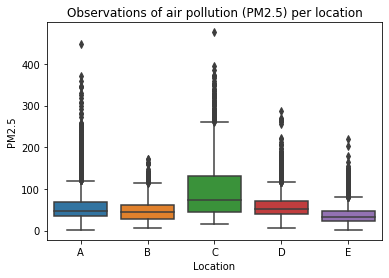

In [7]:
sns.boxplot(data=data, x='location', y='target', order=location_order).set(title='Observations of air pollution (PM2.5) per location', xlabel='Location', ylabel="PM2.5");

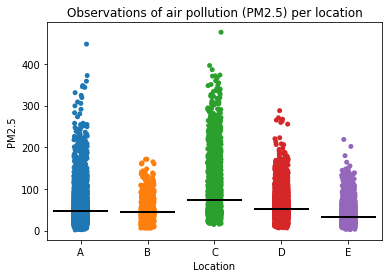

In [8]:
sns.stripplot(data=data, x='location', y='target', order=location_order, zorder=1)
sns.boxplot(data=data, x='location', y='target', order=location_order, zorder=2,
    medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False}, showfliers=False, showbox=False, showcaps=False
    ).set(title='Observations of air pollution (PM2.5) per location', xlabel='Location', ylabel='PM2.5')
plt.savefig('images/pm2_5_per_location.jpg');

## Metadata (influence of surrounding on pollution)

### Cooking with charcoal (and firewood), and burning of waste

In [9]:
meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential', 'popn', 'hh', 'hh_cook_charcoal', 'hh_cook_firewood', 'hh_burn_waste']]

,location,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste
0,A,NaN,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142
1,B,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809,22243,5735,116,1144,239
2,C,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835
3,D,NaN,265.896472,NaN,339.693908,76.024389,11.601442,3596,663,7,651,99
4,E,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589,6064,1297,985,26,43


In [10]:
# The following doesn't include hh_cook_firewood!

# cook_burn = meta[['location', 'hh_cook_charcoal', 'hh_cook_firewood', 'hh_burn_waste']].set_index('location')
cook_burn = meta[['location', 'hh_cook_charcoal', 'hh_burn_waste']].set_index('location')

# cook_burn.columns = 'cooking w/ charcoal', 'cooking w/ firewood', 'burning waste'
cook_burn.columns = 'cooking w/ charcoal', 'burning waste'
cook_burn

,cooking w/ charcoal,burning waste
location,,
A,508,142
B,116,239
C,21316,9835
D,7,99
E,985,43


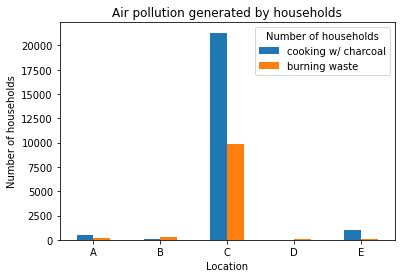

In [11]:
ax = cook_burn.plot(kind='bar')
ax.set(xlabel = 'Location', ylabel='Number of households', title='Air pollution generated by households')
ax.legend(title='Number of households')
plt.xticks(rotation=0)
ax.get_figure().savefig('images/n_hh_cooking_burning.jpg')

### Roads nearby

In [12]:
meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary', 'dist_tertiary', 'dist_unclassified', 'dist_residential']].set_index('location')

,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential
location,,,,,,
A,NaN,14.695789,343.595039,575.917422,330.609776,254.307415
B,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809
C,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350
D,NaN,265.896472,NaN,339.693908,76.024389,11.601442
E,850.423131,NaN,1738.872942,137.722087,449.591885,3.836589


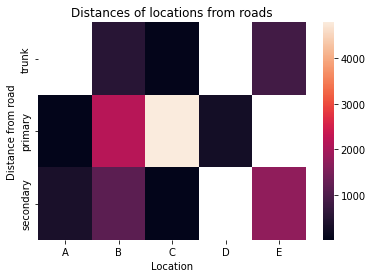

In [13]:
# without 'dist_tertiary 'dist_unclassified', 'dist_residential'
dist_roads = meta[['location', 'dist_trunk', 'dist_primary', 'dist_secondary']].set_index('location')
dist_roads.columns = ['trunk', 'primary', 'secondary']
sns.heatmap(dist_roads.T).set(xlabel='Location', ylabel='Distance from road', title='Distances of locations from roads');
plt.savefig('images/dist_roads.jpg')

## Distribution of features

In [14]:
def fmt_title_ylabel(stat_measure_str, unit):
    stat_measure = stat_measure_str.split('_')
    stat, measure = stat_measure[0], '_'.join(stat_measure[1:])
    title = f"{stat.title()} {features_pretty[measure].lower()} per location"
    if unit is not None:
        ylabel = f"{stat.title()} {features_pretty[measure].lower()} ({unit})"
    else:
        ylabel = f"{stat.title()} {features_pretty[measure].lower()}"
    return title, ylabel

def boxplots_per_location(y, unit=None, save=False):
    title, ylabel = fmt_title_ylabel(y, unit)
    sns.boxplot(data=data, x='location', y=y, order=location_order).set(title=title, xlabel='Location', ylabel=ylabel)
    if save:
        plt.savefig(f"images/boxplots_{y}_per_location.jpg")

def stripplots_per_location(y, unit=None, save=False, median=False):
    title, ylabel = fmt_title_ylabel(y, unit)
    sns.stripplot(data=data, x='location', y=y, order=location_order, zorder=1)
    print(y)
    if median:
        sns.boxplot(data=data, x='location', y=y, order=location_order, zorder=2,
            medianprops={'color': 'k', 'ls': '-', 'lw': 2}, whiskerprops={'visible': False},
            showfliers=False, showbox=False, showcaps=False)
    plt.title(title)
    plt.xlabel('Location')
    plt.ylabel(ylabel)
    if save:
        plt.savefig(f"images/stripplots_{y}_per_location.jpg")


### Temperature

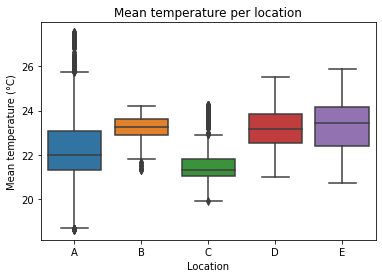

In [15]:
boxplots_per_location('mean_temp', '°C')

mean_temp


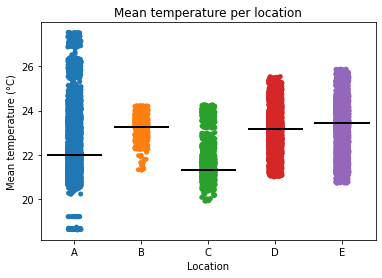

In [16]:
stripplots_per_location('mean_temp', '°C', median=True, save=True)

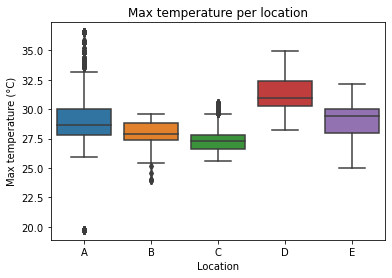

In [17]:
boxplots_per_location('max_temp', '°C')

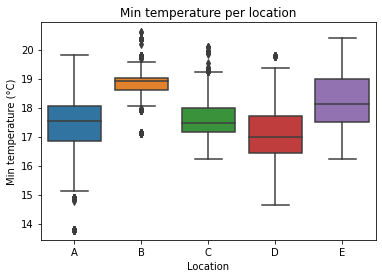

In [18]:
boxplots_per_location('min_temp', '°C')

### Atmos. pressure

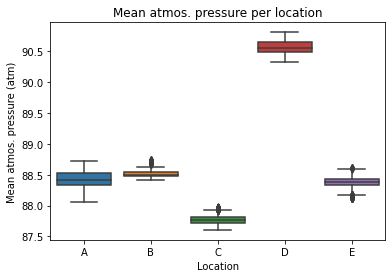

In [19]:
boxplots_per_location('mean_atmos_press', 'atm')

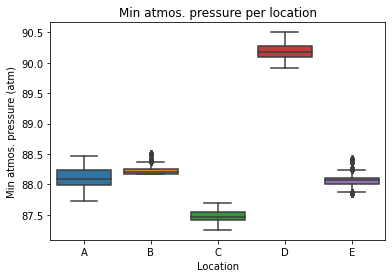

In [20]:
boxplots_per_location('min_atmos_press', 'atm')

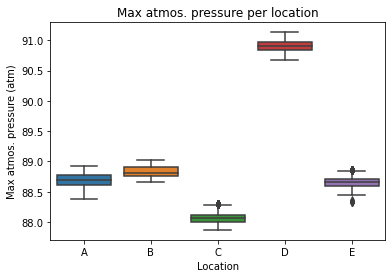

In [21]:
boxplots_per_location('max_atmos_press', 'atm')

mean_atmos_press


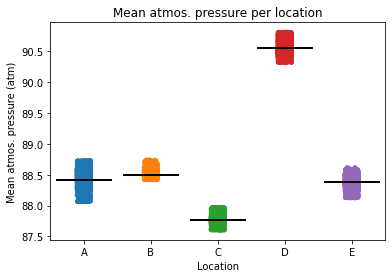

In [22]:
stripplots_per_location('mean_atmos_press', 'atm', median=True, save=True)

### Wind speed

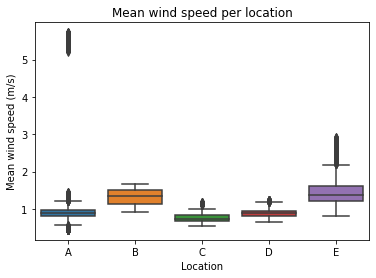

In [23]:
boxplots_per_location('mean_wind_spd', 'm/s')

mean_wind_spd


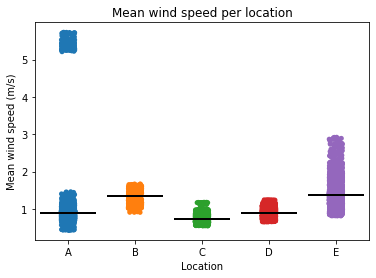

In [24]:
stripplots_per_location('mean_wind_spd', 'm/s', median=True, save=True)

### Precipitation

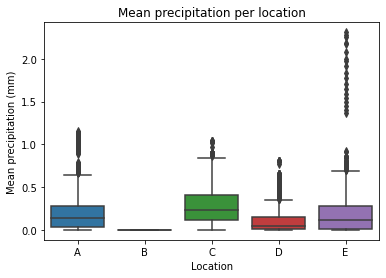

In [25]:
boxplots_per_location('mean_precip', 'mm')

mean_precip


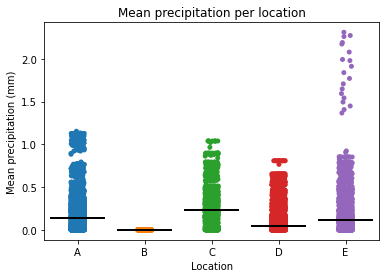

In [26]:
stripplots_per_location('mean_precip', 'mm', median=True, save=True)

## Data quality

### NaNs per observation

In [27]:
nans_per_obs = data_less_raw.copy()

for feature in features_pretty.keys(): 
    nans_per_obs[feature] = nans_per_obs[feature].apply(lambda x: np.count_nonzero(np.isnan(x)))

In [28]:
nans_per_obs

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,105,105,105,105,105,105,45.126304
1,ID_train_1,D,0,0,0,0,0,0,79.131702
2,ID_train_10,A,1,1,1,46,46,1,32.661304
3,ID_train_100,A,0,0,0,51,51,0,53.850238
4,ID_train_1000,A,91,91,91,91,91,91,177.418750
...,...,...,...,...,...,...,...,...,...
15534,ID_train_9995,A,0,0,1,48,48,0,44.850286
15535,ID_train_9996,E,0,0,0,6,6,0,24.330455
15536,ID_train_9997,D,1,0,1,0,0,0,38.972128
15537,ID_train_9998,D,0,0,0,0,0,0,41.720952


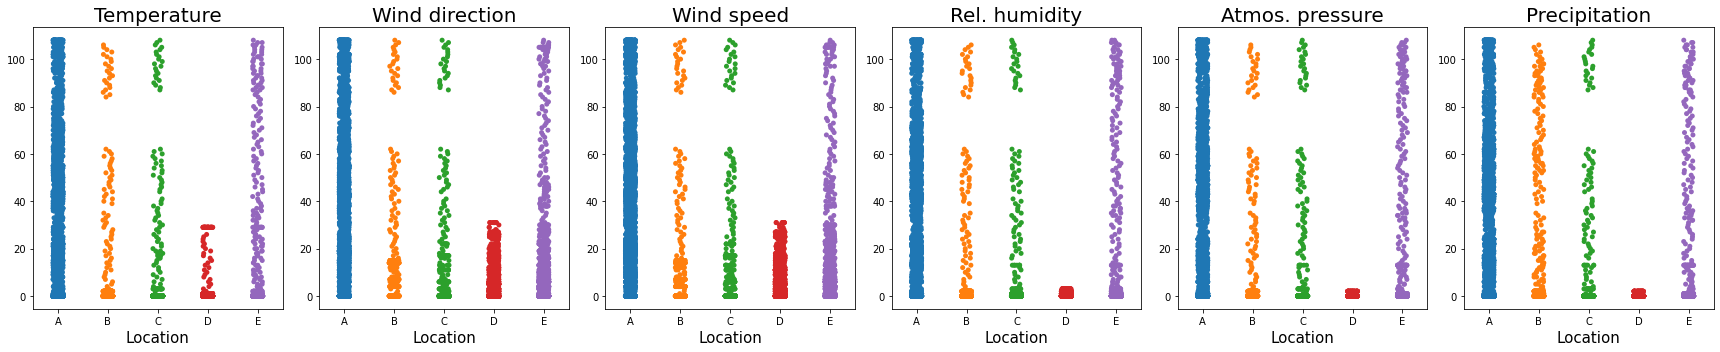

In [29]:
fig, ax = plt.subplots(1, len(features_pretty.keys()), figsize=(4*len(features_pretty.keys()),5))
for i, f in enumerate(features_pretty.keys()):
    sns.stripplot(data=nans_per_obs, x='location', y=f, order=location_order, ax=ax[i])
    ax[i].set_title(features_pretty[f], fontsize=20)
    ax[i].set_xlabel('Location', fontsize=15)
    ax[i].set_ylabel('')
# fig.suptitle('Missing Values in Observation', fontsize=30)
fig.tight_layout()

Wind dir. and Wind speed similar to Temp., Atmos. pressure similar to Rel. humidity, therefore they are left out in the following graphs.

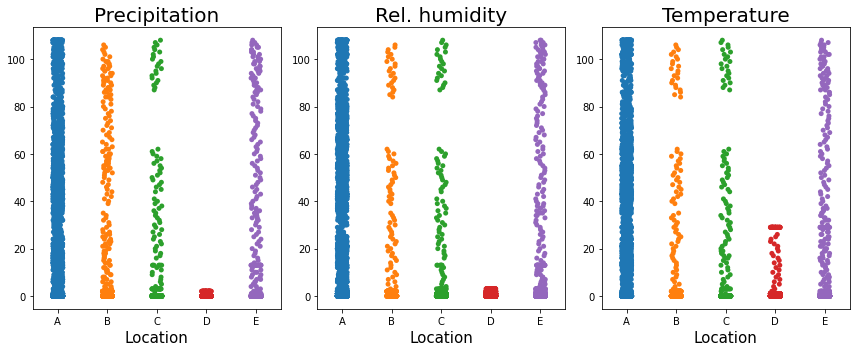

In [30]:
features_order = ['precip', 'rel_humidity', 'temp']
fig, ax = plt.subplots(1, len(features_order), figsize=(4*len(features_order),5))
for i, f in enumerate(features_order):
    sns.stripplot(data=nans_per_obs, x='location', y=f, order=location_order, ax=ax[i])
    ax[i].set_title(features_pretty[f], fontsize=20)
    ax[i].set_xlabel('Location', fontsize=15)
    ax[i].set_ylabel('')
# fig.suptitle('Missing Values in Observation', fontsize=30)
fig.tight_layout()
fig.savefig('images/missing_values_in_observation.jpg')

### NaNs per location (count, mean, median, max)

In [31]:
# sum
nans_per_loc = nans_per_obs.groupby(['location']).sum()
nans_per_loc

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,
A,99461,97630,99225,149105,149105,97630,295305.872256
B,4244,8246,4244,6290,6290,4244,38246.434159
C,4137,4116,4229,5376,5376,4116,171394.724878
D,1981,123,1427,14119,14119,123,290196.429703
E,9418,8663,8987,19997,19997,8663,109885.650665


In [32]:
# mean
mean_nans_per_loc = nans_per_obs.groupby(['location']).mean()
mean_nans_per_loc

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,
A,19.418391,19.060914,19.372316,29.110699,29.110699,19.060914,57.654407
B,5.533246,10.750978,5.533246,8.200782,8.200782,5.533246,49.864973
C,2.359954,2.347975,2.412436,3.066743,3.066743,2.347975,97.772233
D,0.396994,0.024649,0.285972,2.829459,2.829459,0.024649,58.155597
E,3.239766,2.980048,3.091503,6.878913,6.878913,2.980048,37.800361


In [33]:
# TODO check
# median
median_nans_per_loc = nans_per_obs.groupby(['location']).median()
median_nans_per_loc

,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,
A,0.0,0.0,1.0,18.0,18.0,0.0,46.801340
B,0.0,0.0,0.0,0.0,0.0,0.0,43.527442
C,0.0,0.0,0.0,0.0,0.0,0.0,72.774667
D,0.0,0.0,0.0,0.0,0.0,0.0,50.526938
E,0.0,0.0,0.0,0.0,0.0,0.0,32.986667


In [34]:
# max
max_nans_per_loc = nans_per_obs.groupby(['location']).max()
max_nans_per_loc

,ID,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
location,,,,,,,,
A,ID_train_9995,108,108,108,108,108,108,447.340000
B,ID_train_9959,106,106,106,108,108,106,171.252564
C,ID_train_9999,108,108,108,108,108,108,475.820000
D,ID_train_9998,29,2,3,31,31,2,287.689412
E,ID_train_9996,108,108,108,108,108,108,218.505385
